In [3]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from matplotlib import ticker, cm
from math import sqrt, pi
from numpy import exp, cos, sin
from numpy.linalg import norm
import seaborn as sns
import time

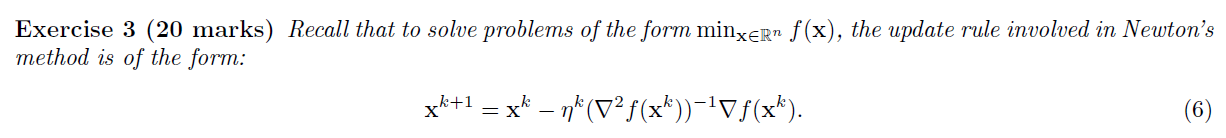

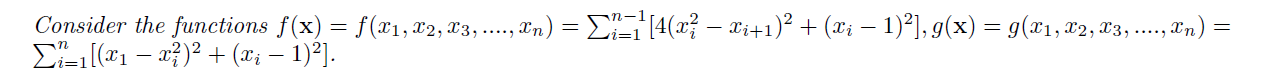

$B_0 = I_n$, since we need it to be PSD and invertible and symmetric.

According to Hessian Update Rule: $B^{k+1} = (I-\mu^k \mathbf{s}^k (\mathbf{y}^k)^\top) B^{k} (I-\mu^k \mathbf{y}^k (\mathbf{s}^k)^\top) + \mu^k \mathbf{s}^k (\mathbf{s}^k)^\top$

 where $\mu^k = \frac{1}{(\mathbf{y}^k)^\top \mathbf{s}^k}$

 where $\mathbf{y}^k = (\nabla q(\mathbf{x}^{k+1})- \nabla {q} (\mathbf{x}^k))$ and $\mathbf{s}^k = (\mathbf{x}^{k+1}-\mathbf{x}^{k})$.

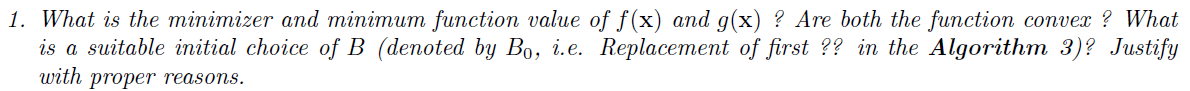

Minimizer for $f(x)$ is $[1,1,...,1]$ as it achieves its global minimum which is 0 at this point. Yes the function is convex as it is sum of convex functions. For $g(x)$ also the minimizer is $[1,1,...,1]$ and minimum is 0. Since all we are trying to do is replace inverse of Hessian with easily computable inverse, $B_0$ we can take to be directly the **identity**, since we just need it to be PSD and invertible and symmetric.

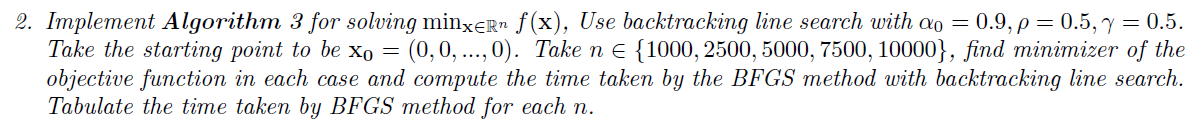

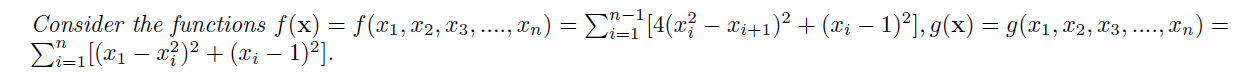

$\nabla_{x_i}{f(x)} = -8(x_{i-1}^2 - x_i) + 8(x_i^2-x_{i+1})(2x_i) + 2(x_i-1)$

when $i = 2,...,n-1$

for i = n:
$\nabla_{x_n}f(x) = -8(x_{n-1}^2 - x_n)$

for i = 1:
$\nabla_{x_1}f(x) = 8(x_{1}^2 - x_2)(2x_1) + 2(x_1-1)$

In [ ]:
def fx(xk):
  length = len(xk)
  sum = 0
  for i in range(length-1):
    sum+= 4*(xk[i]**2 - xk[i+1])**2 + (xk[i]-1)**2
  return sum

def gradient_fx(xk):
  n = len(xk)
  grad = []
  grad.append( 16*xk[0]*(xk[0]**2 - xk[1]) + 2*(xk[0]-1) )
  for i in range(1, n-1):
    grad.append(  -8*(xk[i-1]**2 - xk[i]) + 16*xk[i]*(xk[i]**2 - xk[i+1]) + 2*(xk[i]-1) )
  grad.append(-8*(xk[n-2]**2 - xk[n-1]))
  return np.array(grad)

In [ ]:
fx([1,3])

16

In [ ]:
gradient_fx(np.array([1,5]))

array([-64,  32])

In [ ]:

def get_alpha_bfgs(xk, alpha0, rho, gamma, Bk):
  alpha = alpha0
  pk = -gradient_fx(xk)
  while fx(xk + alpha*Bk@pk) > (fx(xk) + gamma*alpha*gradient_fx(xk)@Bk@pk):
    alpha = rho*alpha
  return alpha


def bfgs(x0, tau, alpha0, rho, gamma, max_iter=500):
  start_time = time.time()
  xk = np.copy(x0)
  n = len(x0)
  Bk = np.eye(n)
  count = 0
  pk = gradient_fx(xk)
  xks = []
  xks.append(xk)
  while (norm(pk)>tau):
    if count > max_iter:
      break

    alpha = get_alpha_bfgs(xk, alpha0, rho, gamma, Bk)
    xnext = xk - alpha*(Bk@pk)

    # print("new xk: ", xk[0:5])
    ## new Bk+1 computation
    sk = xnext - xk
    yk = gradient_fx(xnext) - gradient_fx(xk)
    # BFGS update formula
    Bk = np.dot((np.eye(len(xk)) - np.outer(sk, yk) / np.dot(yk, sk)), np.dot(Bk, (np.eye(len(xk)) - np.outer(yk, sk) / np.dot(yk, sk)))) + np.outer(sk, sk) / np.dot(yk, sk)

    xk = xnext
    pk = gradient_fx(xk)
    # print("grad is: ", pk[0:5])
    # print("grad norm is: ", norm(pk))
    xks.append(xk)
    count += 1

  end_time = time.time()
  time_elapsed = end_time - start_time
  return count, xk, fx(xk), xks, time_elapsed

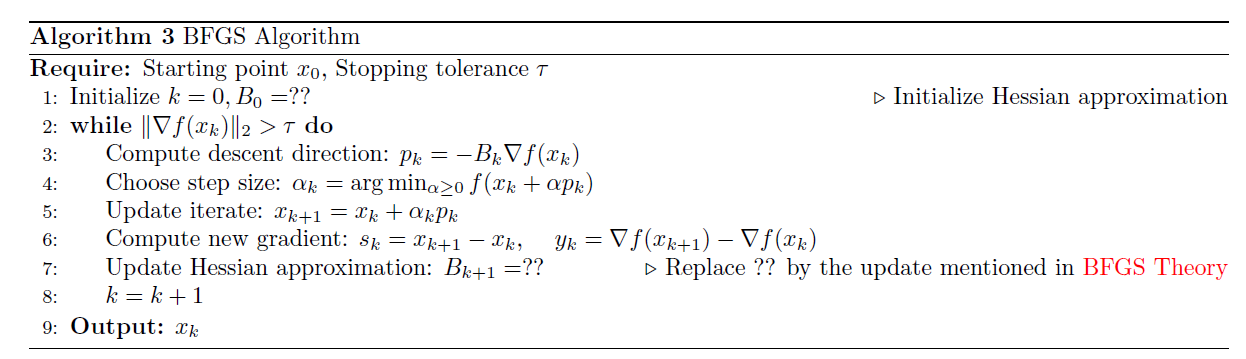

In [ ]:
alpha0 = 0.9
rho = 0.5
gamma = 0.5
ns = [1000, 2500, 5000, 7500, 10000]
tau = 1
elapsedtimelistforfx_inbfgs = []
for n in ns:
  x0 = [0 for i in range(n)]
  count, minimizer, minimum, xks, time_elapsed=bfgs(x0,tau, alpha0, rho, gamma)
  print(f"for n = {n}")
  print(f"total iterations: {count} | minimizer: {minimizer[0:5]} | minimum: {minimum} | time taken: {time_elapsed}")
  print("----------------------------------------------------------------")
  elapsedtimelistforfx_inbfgs.append(time_elapsed)

for n = 1000
total iterations: 20 | minimizer: [0.99983034 0.99977006 1.0012824  0.99946833 1.00201175] | minimum: 0.09273507643457007 | time taken: 4.579495906829834
----------------------------------------------------------------
for n = 2500
total iterations: 23 | minimizer: [0.99900058 0.99916273 0.99931754 0.99866577 0.99976473] | minimum: 0.05162392440299958 | time taken: 63.367961168289185
----------------------------------------------------------------
for n = 5000
total iterations: 41 | minimizer: [1.00542991 1.00585451 1.00503507 1.00470497 1.00270162] | minimum: 0.06629246047663098 | time taken: 760.5679562091827
----------------------------------------------------------------
for n = 7500
total iterations: 39 | minimizer: [1.00036005 1.000314   0.99809466 0.99946437 0.99768334] | minimum: 0.07375269415430305 | time taken: 2309.024312019348
----------------------------------------------------------------
for n = 10000
total iterations: 38 | minimizer: [0.99914355 0.9978401  

In [ ]:
def gx(xk):
  length = len(xk)
  sum = 0
  for i in range(length):
    sum+= (xk[0] - xk[i]**2)**2 + (xk[i]-1)**2
  return sum

def gradient_gx(xk):
  n = len(xk)
  grad = []
  first_grad = 0
  for i in range(1,n):
    first_grad += 2*(xk[0] - xk[i]**2)
  first_grad += 2*(xk[0]-1) + 2*(xk[0] - xk[0]**2)*(1-2*xk[0])
  grad.append( first_grad )
  for i in range(1, n):
    grad.append( -4*(xk[0] - xk[i]**2)*xk[i] + 2*(xk[i]-1) )
  return np.array(grad)

In [ ]:
gradient_gx([1 for i in range(5)])

array([0, 0, 0, 0, 0])

In [ ]:

def get_alpha_bfgs(xk, alpha0, rho, gamma, Bk):
  alpha = alpha0
  pk = -gradient_gx(xk)
  while gx(xk + alpha*Bk@pk) > (gx(xk) + gamma*alpha*gradient_gx(xk)@Bk@pk):
    alpha = rho*alpha
  return alpha


def bfgs(x0, tau, alpha0, rho, gamma, max_iter=500):
  start_time = time.time()
  xk = np.copy(x0)
  n = len(x0)
  Bk = np.eye(n)
  count = 0
  pk = gradient_gx(xk)
  xks = []
  xks.append(xk)
  while (norm(pk)>tau):
    if count > max_iter:
      break

    alpha = get_alpha_bfgs(xk, alpha0, rho, gamma, Bk)
    xnext = xk - alpha*(Bk@pk)

    # print("new xk: ", xk[0:5])
    ## new Bk+1 computation
    sk = xnext - xk
    yk = gradient_gx(xnext) - gradient_gx(xk)
    # BFGS update formula
    Bk = np.dot((np.eye(len(xk)) - np.outer(sk, yk) / np.dot(yk, sk)), np.dot(Bk, (np.eye(len(xk)) - np.outer(yk, sk) / np.dot(yk, sk)))) + np.outer(sk, sk) / np.dot(yk, sk)

    xk = xnext
    pk = gradient_gx(xk)
    # print("grad is: ", pk[0:5])
    # print("grad norm is: ", norm(pk))
    xks.append(xk)
    count += 1

  end_time = time.time()
  time_elapsed = end_time - start_time
  return count, xk, gx(xk), xks, time_elapsed

In [ ]:
alpha0 = 0.9
rho = 0.5
gamma = 0.5
ns = [1000, 2500, 5000, 7500, 10000]
tau = 1
elapsedtimelistforgx_inbfgs = []
for n in ns:
  x0 = [0 for i in range(n)]
  count, minimizer, minimum, xks, time_elapsed=bfgs(x0,tau, alpha0, rho, gamma)
  print(f"for n = {n}")
  print(f"total iterations: {count} | minimizer: {minimizer[0:5]} | minimum: {minimum} | time taken: {time_elapsed}")
  print("----------------------------------------------------------------")
  elapsedtimelistforgx_inbfgs.append(time_elapsed)

for n = 1000
total iterations: 5 | minimizer: [0.99921415 0.99977464 0.99977464 0.99977464 0.99977464] | minimum: 0.00016420670144070933 | time taken: 1.0442709922790527
----------------------------------------------------------------
for n = 2500
total iterations: 6 | minimizer: [0.99992208 0.99997496 0.99997496 0.99997496 0.99997496] | minimum: 3.5167993666482156e-06 | time taken: 16.333229064941406
----------------------------------------------------------------
for n = 5000
total iterations: 6 | minimizer: [0.99992143 0.99997476 0.99997476 0.99997476 0.99997476] | minimum: 7.142447349652737e-06 | time taken: 109.05728578567505
----------------------------------------------------------------
for n = 7500
total iterations: 6 | minimizer: [0.99992017 0.9999713  0.9999713  0.9999713  0.9999713 ] | minimum: 9.962124310022795e-06 | time taken: 353.33301997184753
----------------------------------------------------------------
for n = 10000
total iterations: 6 | minimizer: [0.9999211  0.9

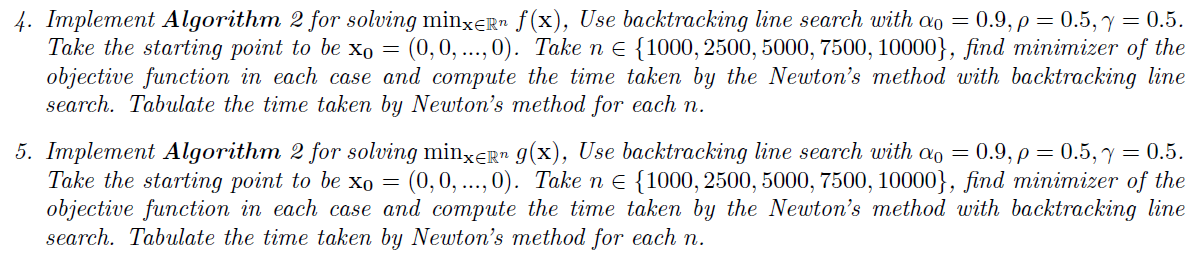

In [4]:
def fx(xk):
  length = len(xk)
  sum = 0
  for i in range(length-1):
    sum+= 4*(xk[i]**2 - xk[i+1])**2 + (xk[i]-1)**2
  return sum

def gradient_fx(xk):
  n = len(xk)
  grad = []
  grad.append( 16*xk[0]*(xk[0]**2 - xk[1]) + 2*(xk[0]-1) )
  for i in range(1, n-1):
    grad.append(  -8*(xk[i-1]**2 - xk[i]) + 16*xk[i]*(xk[i]**2 - xk[i+1]) + 2*(xk[i]-1) )
  grad.append(-8*(xk[n-2]**2 - xk[n-1]))
  return np.array(grad)


def hessian_fx(xk):
  n = len(xk)
  hessn = np.zeros((n,n))
  hessn[0][0] = 2 -4*(xk[0] - xk[0]**2) + 2*(1- 2*xk[0])**2
  if n>=2:
    for i in range(1,n):
      hessn[0][0] = hessn[0][0] + 2
      hessn[0][i] = -4*xk[i]
  for i in range(1,n):
    hessn[i][i] = 2 - 4*(xk[0] - xk[i]*2) + 8*(xk[i]**2)
    hessn[i][0] = hessn[0][i] #because it is a symmetric matrix
  return hessn

def dk_fx(xk):
  return np.linalg.inv(hessian_fx(xk))

In [5]:
hessian_fx([2,2,2,2,2])

array([[36., -8., -8., -8., -8.],
       [-8., 42.,  0.,  0.,  0.],
       [-8.,  0., 42.,  0.,  0.],
       [-8.,  0.,  0., 42.,  0.],
       [-8.,  0.,  0.,  0., 42.]])

In [ ]:
def get_alpha_newton(xk, alpha0, rho, gamma, Dk):
  alpha = alpha0
  pk = -gradient_fx(xk)
  while fx(xk + alpha*Dk@pk) > (fx(xk) + gamma*alpha*gradient_fx(xk)@Dk@pk):
    alpha = rho*alpha
  return alpha

def newton_method_with_backtracking(x0, tau, alpha0, rho, gamma):
  start_time = time.time()
  xk = np.copy(x0)
  count = 0
  pk = gradient_fx(xk)
  xks = []
  xks.append(xk)
  while norm(pk)>tau:
    Dk = dk_fx(xk)
    alpha = get_alpha_newton(xk, alpha0, rho, gamma, Dk)
    xk = xk - alpha*Dk@pk
    pk = gradient_fx(xk)
    xks.append(xk)
    count += 1
  end_time = time.time()
  time_elapsed = end_time - start_time
  return count, xk, fx(xk), xks, time_elapsed

In [6]:
alpha0 = 0.9
rho = 0.5
gamma = 0.5
ns = [5000, 7500, 10000]
tau = 1
elapsedtimelistforfx_innewton = []
for n in ns:
  x0 = [0 for i in range(n)]
  count, minimizer, minimum, xks, time_elapsed=newton_method_with_backtracking(x0,tau, alpha0, rho, gamma)
  print(f"for n = {n}")
  print(f"total iterations: {count} | minimizer: {minimizer[0:5]} | minimum: {minimum} | time taken: {time_elapsed}")
  print("----------------------------------------------------------------")
  elapsedtimelistforfx_innewton.append(time_elapsed)

KeyboardInterrupt: 

In [6]:
def gx(xk):
  length = len(xk)
  sum = 0
  for i in range(length):
    sum+= (xk[0] - xk[i]**2)**2 + (xk[i]-1)**2
  return sum

def gradient_gx(xk):
  n = len(xk)
  grad = []
  first_grad = 0
  for i in range(1,n):
    first_grad += 2*(xk[0] - xk[i]**2)
  first_grad += 2*(xk[0]-1) + 2*(xk[0] - xk[0]**2)*(1-2*xk[0])
  grad.append( first_grad )
  for i in range(1, n):
    grad.append( -4*(xk[0] - xk[i]**2)*xk[i] + 2*(xk[i]-1) )
  return np.array(grad)

def hessian_gx(xk):
  n = len(xk)
  hessn = np.zeros((n,n))
  hessn[0][0] = 2 -4*(xk[0] - xk[0]**2) + 2*(1- 2*xk[0])**2
  if n>=2:
    for i in range(1,n):
      hessn[0][0] = hessn[0][0] + 2
      hessn[0][i] = -4*xk[i]

  for i in range(1,n):
    hessn[i][i] = 2 - 4*(xk[0] - xk[i]*2) + 8*(xk[i]**2)
    hessn[i][0] = hessn[0][i] #because it is a symmetric matrix
  return hessn


def dk_gx(xk):
  return np.linalg.inv(hessian_gx(xk))

def get_alpha_newton(xk, alpha0, rho, gamma, Dk):
  alpha = alpha0
  pk = -gradient_gx(xk)
  while gx(xk + alpha*Dk@pk) > (gx(xk) + gamma*alpha*gradient_gx(xk)@Dk@pk):
    alpha = rho*alpha
  return alpha

def newton_method_with_backtracking(x0, tau, alpha0, rho, gamma):
  start_time = time.time()
  xk = np.copy(x0)
  count = 0
  pk = gradient_gx(xk)
  xks = []
  xks.append(xk)
  while norm(pk)>tau:
    Dk = dk_gx(xk)
    alpha = get_alpha_newton(xk, alpha0, rho, gamma, Dk)
    xk = xk - alpha*Dk@pk
    pk = gradient_gx(xk)
    xks.append(xk)
    count += 1
  end_time = time.time()
  time_elapsed = end_time - start_time
  return count, xk, gx(xk), xks, time_elapsed


In [ ]:
  alpha0 = 0.9
rho = 0.5
gamma = 0.5
ns = [1000, 2500, 5000, 7500, 10000]
tau = 1
elapsedtimelistforgx_innewton = []
for n in ns:
  x0 = [0 for i in range(n)]
  count, minimizer, minimum, xks, time_elapsed=newton_method_with_backtracking(x0,tau, alpha0, rho, gamma)
  print(f"for n = {n}")
  print(f"total iterations: {count} | minimizer: {minimizer[0:5]} | minimum: {minimum} | time taken: {time_elapsed}")
  print("----------------------------------------------------------------")
  elapsedtimelistforgx_innewton.append(time_elapsed)

for n = 1000
total iterations: 11 | minimizer: [0.97208921 0.98594193 0.98594193 0.98594193 0.98594193] | minimum: 0.198946868046022 | time taken: 1.6708474159240723
----------------------------------------------------------------
for n = 2500
total iterations: 12 | minimizer: [0.98024379 0.99007637 0.99007637 0.99007637 0.99007637] | minimum: 0.24686307604413413 | time taken: 22.97731065750122
----------------------------------------------------------------
for n = 5000
total iterations: 13 | minimizer: [0.98610682 0.99303202 0.99303202 0.99303202 0.99303202] | minimum: 0.24309609700354048 | time taken: 166.59603190422058
----------------------------------------------------------------
for n = 7500
total iterations: 14 | minimizer: [0.99025575 0.99511743 0.99511743 0.99511743 0.99511743] | minimum: 0.17896061495935955 | time taken: 571.9968736171722
----------------------------------------------------------------
for n = 10000
total iterations: 14 | minimizer: [0.9902479  0.99511381 0

### Screenshots:

BFGS for f(x): [Screenshot in case I lose the output]
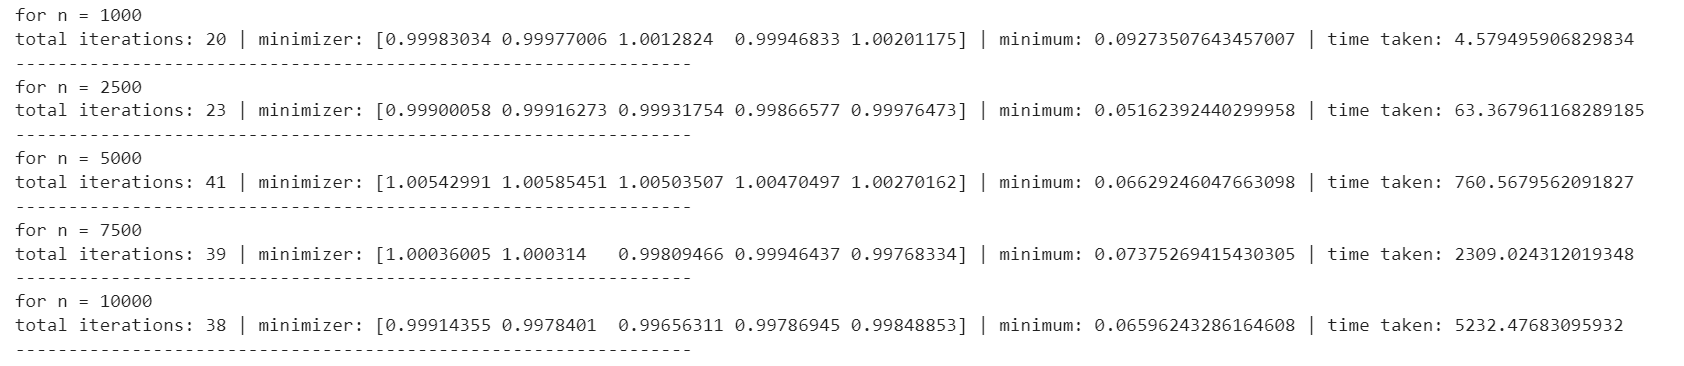



NEWTON'S for f(x)
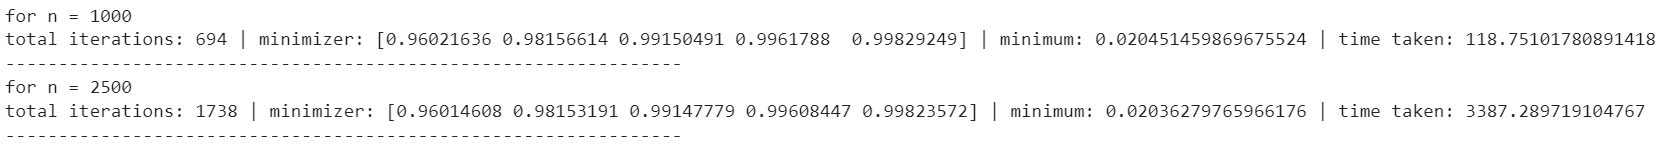

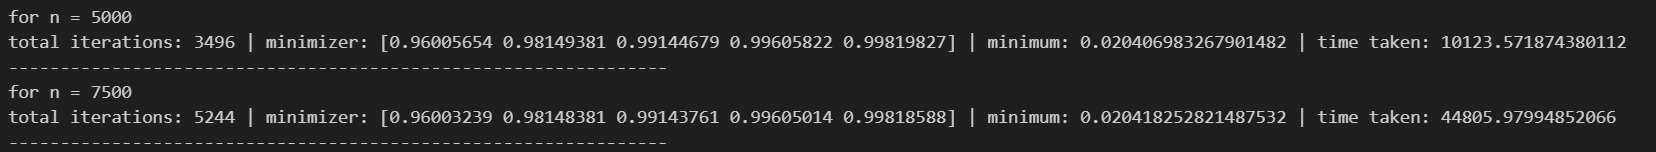

BFGS for g(x):
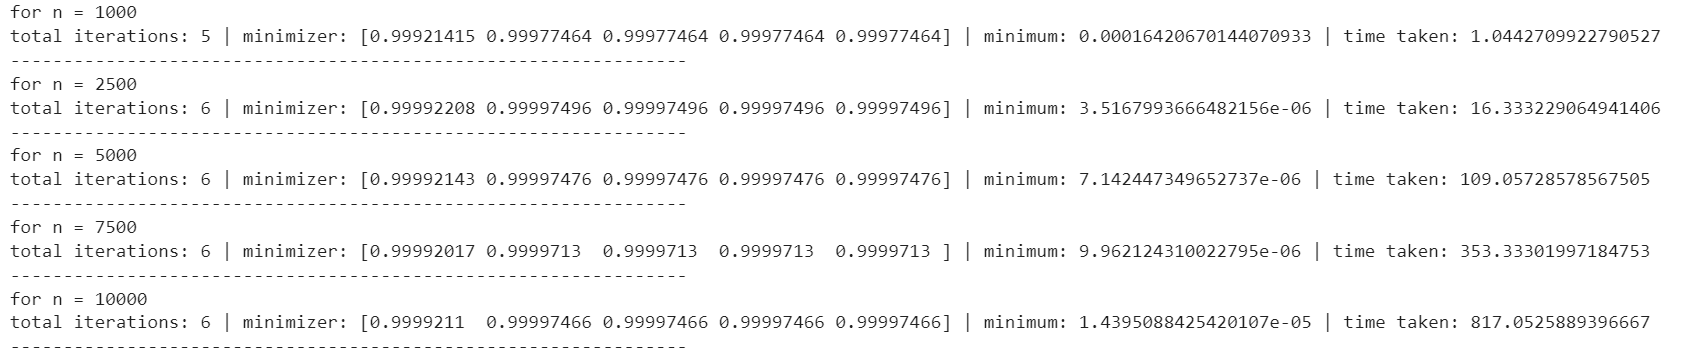

NEWTONS for g(x):
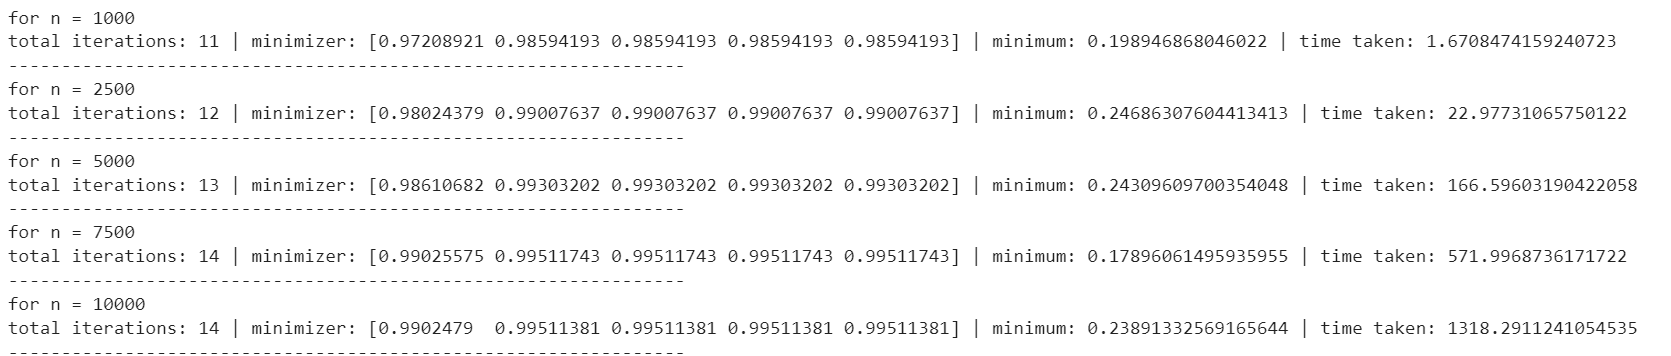